<a href="https://colab.research.google.com/github/Aggarwalmansi/GENAI/blob/main/AI_Studio_Stage2_CIFAR10_MansiAgarwal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



cuda


In [ ]:
import numpy as np
import torch
import random

In [2]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)
# all set to 42


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


### Objective: Train a small CNN on a subset of CIFAR-10 and systematically evaluate its performance through controlled experiments.


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])


In [5]:
train_dataset_full = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


100%|██████████| 170M/170M [00:04<00:00, 40.5MB/s]


In [6]:
print("Total training samples:", len(train_dataset_full))
print("Total test samples:", len(test_dataset))


Total training samples: 50000
Total test samples: 10000


In [7]:
subset_size = 8000

indices = torch.randperm(len(train_dataset_full))[:subset_size]
train_subset = torch.utils.data.Subset(train_dataset_full, indices)

print("Subset size:", len(train_subset))


Subset size: 8000


In [8]:
train_size = int(0.8 * subset_size)
val_size = subset_size - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    train_subset,
    [train_size, val_size]
)
print(len(train_dataset))
print(len(val_dataset))

6400
1600


In [9]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [10]:
classes = train_dataset_full.classes
print(classes)


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


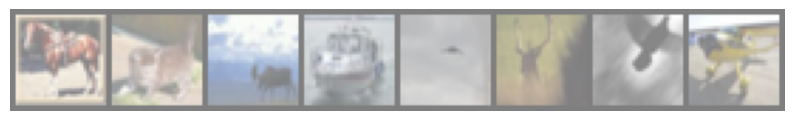

Labels: ['horse', 'cat', 'deer', 'ship', 'airplane', 'deer', 'bird', 'airplane']


In [11]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")

dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(10,4))
imshow(torchvision.utils.make_grid(images[:8]))
plt.show()

print("Labels:", [classes[labels[j]] for j in range(8)])


#### images of cat dog looking similar ,images are little blur




In [12]:
from collections import Counter

subset_labels = [train_dataset_full.targets[i] for i in indices]
class_counts = Counter(subset_labels)

for idx, count in class_counts.items():
    print(classes[idx], ":", count)


frog : 835
bird : 792
ship : 801
truck : 799
deer : 815
dog : 788
horse : 805
airplane : 806
cat : 773
automobile : 786


#### this shows , no major imbalance is there (balanced classes)

In [13]:
sample_image, _ = train_dataset[0]
print("Image shape:", sample_image.shape)


Image shape: torch.Size([3, 32, 32])


In [14]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)  # flat
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [17]:
model = SimpleCNN().to(device)
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [19]:
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)


Total parameters: 545098


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []



In [21]:
for epoch in range(num_epochs):

    # -------- Training Phase --------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    # -------- Validation Phase --------
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")


Epoch [1/15] Train Loss: 2.0193, Train Acc: 26.11% | Val Loss: 1.7548, Val Acc: 37.38%
Epoch [2/15] Train Loss: 1.6285, Train Acc: 41.50% | Val Loss: 1.5386, Val Acc: 44.38%
Epoch [3/15] Train Loss: 1.4676, Train Acc: 47.22% | Val Loss: 1.4879, Val Acc: 45.75%
Epoch [4/15] Train Loss: 1.3651, Train Acc: 51.09% | Val Loss: 1.4182, Val Acc: 48.56%
Epoch [5/15] Train Loss: 1.2524, Train Acc: 55.69% | Val Loss: 1.3376, Val Acc: 52.75%
Epoch [6/15] Train Loss: 1.1698, Train Acc: 58.75% | Val Loss: 1.3027, Val Acc: 52.94%
Epoch [7/15] Train Loss: 1.0942, Train Acc: 61.66% | Val Loss: 1.2892, Val Acc: 54.12%
Epoch [8/15] Train Loss: 1.0365, Train Acc: 63.72% | Val Loss: 1.3116, Val Acc: 53.19%
Epoch [9/15] Train Loss: 0.9722, Train Acc: 66.09% | Val Loss: 1.2897, Val Acc: 55.19%
Epoch [10/15] Train Loss: 0.9094, Train Acc: 68.77% | Val Loss: 1.2490, Val Acc: 57.69%
Epoch [11/15] Train Loss: 0.8419, Train Acc: 70.61% | Val Loss: 1.2603, Val Acc: 56.38%
Epoch [12/15] Train Loss: 0.7796, Train A

#### Observation:
The model shows clear signs of overfitting.
Training accuracy increases stedily to 83% while valiation acuracy plateaus around 58% </br>
Validation loss begins to increase after epoch 8–10, indicating reduced generalization.

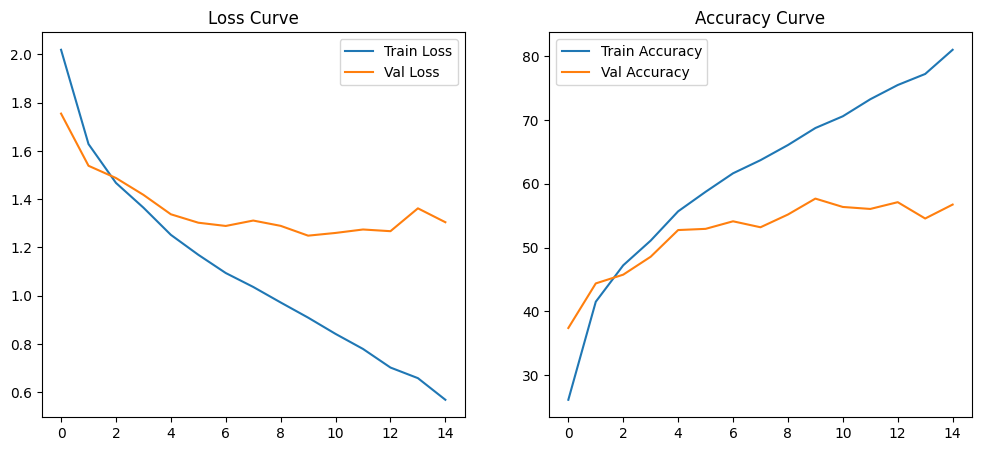

In [22]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title("Accuracy Curve")

plt.show()


In [23]:
# using the alredy known onces
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2470, 0.2435, 0.2616)


### Experiment 1:
Introduce data augmentation and normalization to reduce overfitting
and improve generalization.


In [32]:
# Normalization values commonly used for CIFAR-10
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2470, 0.2435, 0.2616)

# Training transform with augmentation
transform_train_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])

# Validation / Test transform (no augmentation)
transform_eval = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])


In [33]:
train_dataset_full_aug = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train_aug
)

train_dataset_full_eval = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_eval
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_eval
)


In [34]:
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_dataset = torch.utils.data.Subset(train_dataset_full_aug, train_indices)
val_dataset = torch.utils.data.Subset(train_dataset_full_eval, val_indices)


In [35]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [36]:
model_aug = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_aug.parameters(), lr=0.001)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


###### Experiment 1: Data Augmentation + Normalization

Objective:
To reduce overfitting observed in the baseline model by introducing
data augmentation and input normalization while keeping architecture
and optimizer constant.


In [37]:
for epoch in range(num_epochs):

    # -------- Training Phase --------
    model_aug.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model_aug(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    # -------- Validation Phase --------
    model_aug.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model_aug(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")


Epoch [1/15] Train Loss: 1.9157, Train Acc: 29.84% | Val Loss: 1.6244, Val Acc: 41.56%
Epoch [2/15] Train Loss: 1.6172, Train Acc: 40.78% | Val Loss: 1.4828, Val Acc: 45.81%
Epoch [3/15] Train Loss: 1.4982, Train Acc: 45.44% | Val Loss: 1.4436, Val Acc: 47.69%
Epoch [4/15] Train Loss: 1.4290, Train Acc: 48.02% | Val Loss: 1.3740, Val Acc: 51.12%
Epoch [5/15] Train Loss: 1.3730, Train Acc: 50.20% | Val Loss: 1.2898, Val Acc: 53.88%
Epoch [6/15] Train Loss: 1.3021, Train Acc: 53.20% | Val Loss: 1.2761, Val Acc: 54.25%
Epoch [7/15] Train Loss: 1.2456, Train Acc: 55.56% | Val Loss: 1.1848, Val Acc: 58.31%
Epoch [8/15] Train Loss: 1.1942, Train Acc: 56.86% | Val Loss: 1.1602, Val Acc: 58.31%
Epoch [9/15] Train Loss: 1.1518, Train Acc: 59.28% | Val Loss: 1.1740, Val Acc: 58.94%
Epoch [10/15] Train Loss: 1.1197, Train Acc: 60.02% | Val Loss: 1.1578, Val Acc: 58.19%
Epoch [11/15] Train Loss: 1.0980, Train Acc: 60.88% | Val Loss: 1.0968, Val Acc: 60.56%
Epoch [12/15] Train Loss: 1.0707, Train A

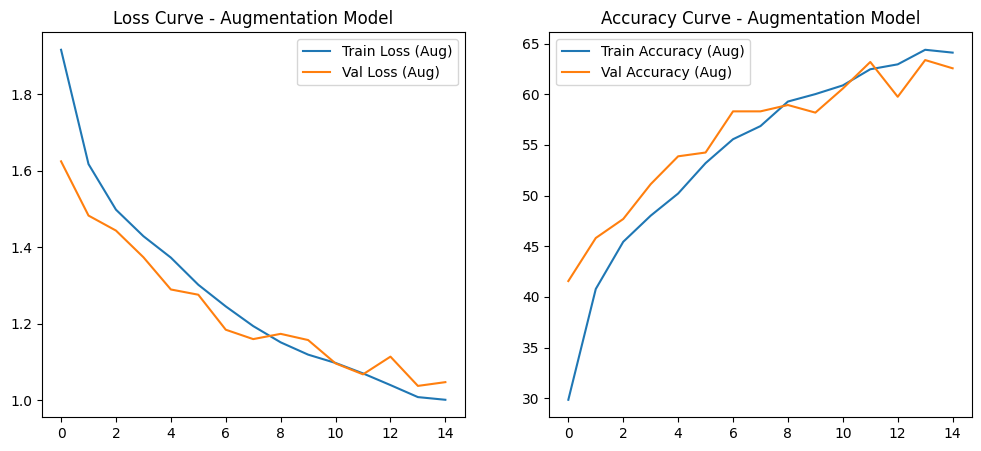

In [42]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss (Aug)')
plt.plot(val_losses, label='Val Loss (Aug)')
plt.legend()
plt.title("Loss Curve - Augmentation Model")

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy (Aug)')
plt.plot(val_accuracies, label='Val Accuracy (Aug)')
plt.legend()
plt.title("Accuracy Curve - Augmentation Model")

plt.show()


#### Experiment 1: Data Augmentation and Normalization

The baseline model exhibited significant overfitting:

Training Accuracy: ~83%

Validation Accuracy: ~58%

Generalization Gap: ~25%

Validation loss began increasing after epoch 8–10, indicating reduced generalization.

To improve robustness, data augmentation(to prevent memorization , and force model to learn invariants) and input normalization(that stabilises gradient and improves convergence behavious) were introduced while keeping all other variables constant.

##### Modifications

Random Horizontal Flip

Random Crop (32×32 with padding=4)

CIFAR-10 standard channel-wise normalization

No changes made to the model architecture, optimizer, learning rate, or training duration.

#### Results

Training Accuracy: ~64%

Validation Accuracy: ~63%

Generalization Gap reduced to ~1–2%

###### Yes training accuracy decreased compared to baseline, validation accuracy improved and algined closely with training.

###### this incidates we reduced overfitting , and result also tell us that high training accuracy does not mean best real world performance everytime

#### Experiment 2:
Introduce Dropout (p=0.5) in the fully connected layer
to further reduce overfitting.


In [38]:
class CNNWithDropout(nn.Module):
    def __init__(self):
        super(CNNWithDropout, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [39]:
# Initialized Dropout model
model_dropout = CNNWithDropout().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dropout.parameters(), lr=0.001)

num_epochs = 15

train_losses_dropout = []
val_losses_dropout = []
train_accuracies_dropout = []
val_accuracies_dropout = []


In [40]:
for epoch in range(num_epochs):

    # -------- Training Phase --------
    model_dropout.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model_dropout(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    train_losses_dropout.append(train_loss)
    train_accuracies_dropout.append(train_accuracy)

    # -------- Validation Phase --------
    model_dropout.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model_dropout(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    val_losses_dropout.append(val_loss)
    val_accuracies_dropout.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")


Epoch [1/15] Train Loss: 2.0786, Train Acc: 22.78% | Val Loss: 1.8550, Val Acc: 35.00%
Epoch [2/15] Train Loss: 1.8137, Train Acc: 32.38% | Val Loss: 1.6251, Val Acc: 41.62%
Epoch [3/15] Train Loss: 1.6826, Train Acc: 37.55% | Val Loss: 1.4918, Val Acc: 45.62%
Epoch [4/15] Train Loss: 1.6286, Train Acc: 40.48% | Val Loss: 1.4466, Val Acc: 46.38%
Epoch [5/15] Train Loss: 1.5775, Train Acc: 42.72% | Val Loss: 1.3973, Val Acc: 51.94%
Epoch [6/15] Train Loss: 1.5357, Train Acc: 43.84% | Val Loss: 1.3495, Val Acc: 51.19%
Epoch [7/15] Train Loss: 1.4929, Train Acc: 45.31% | Val Loss: 1.3698, Val Acc: 52.31%
Epoch [8/15] Train Loss: 1.4489, Train Acc: 47.27% | Val Loss: 1.2846, Val Acc: 53.44%
Epoch [9/15] Train Loss: 1.4272, Train Acc: 47.81% | Val Loss: 1.2841, Val Acc: 54.12%
Epoch [10/15] Train Loss: 1.3857, Train Acc: 48.59% | Val Loss: 1.2309, Val Acc: 56.50%
Epoch [11/15] Train Loss: 1.3743, Train Acc: 49.94% | Val Loss: 1.2050, Val Acc: 57.38%
Epoch [12/15] Train Loss: 1.3268, Train A

#### Experiment 2: Dropout Regularization

Although augmentation significantly reduced overfitting, dropout was introduced in the fully connected layer (p = 0.5) to further regularize the model and evaluate its effect on generalization.

Result

Training Accuracy: ~53%

Validation Accuracy: ~60%

Generalization Gap: ~6–7%

Interpretation

Dropout reduced training accuracy substantially, indicating stronger regularization. However, validation accuracy did not improve beyond the augmentation-only model.

This suggests that augmentation already provided sufficient regularization, and additional dropout may have led to mild underfitting.

##### This experiment demonstrates that more regularization does not always improve performance, and optimal generalization depends on balancing model capacity and training data diversity.


### Confusion Matrix

##### This confusion matrix corresponds to the model trained with data augmentation and normalization (without dropout), which achieved the highest validation accuracy (~63%).

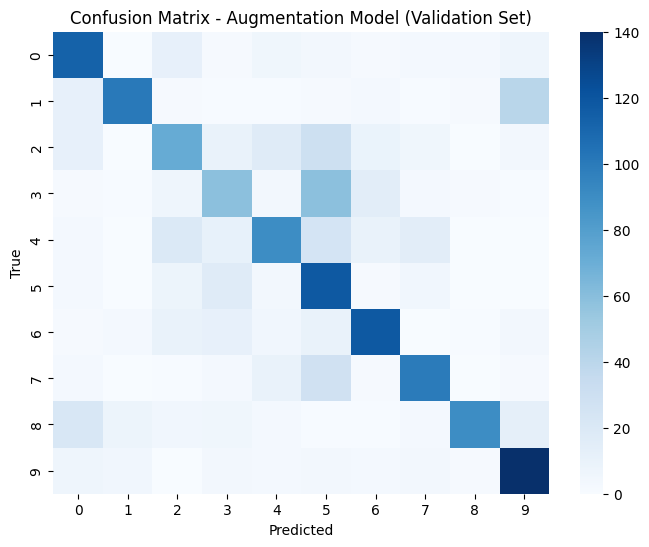

In [41]:
all_preds = []
all_labels = []

model_aug.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model_aug(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix - Augmentation Model (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


#### Class-wise Error Analysis

The confusion matrix shows strong diagonal values, indicating that the model correctly classifies most samples.

However, certain visually similar classes show higher confusion:

Cat vs Dog

Deer vs Horse

Automobile vs Truck

This aligns with earlier qualitative observations that CIFAR-10 images are low resolution (32×32), making fine-grained distinctions difficult.

Overall, the model captures general object structure well but struggles with classes that share similar shapes or textures.